# RBF SVM parameters

**This example illustrates the effect of the parameters gamma and C of the Radial Basis Function (RBF) kernel SVM.**

- **gamma** parameter defines how far the influence of a single training example reaches, with low values meaning ‘far’ and high values meaning ‘close’. The gamma parameters can be seen as the inverse of the radius of influence of samples selected by the model as support vectors.

- **C parameter** trades off correct classification of training examples against maximization of the decision function’s margin. For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy. In other words C behaves as a regularization parameter in the SVM.

The first plot is a visualization of the decision function for a variety of parameter values on a simplified classification problem involving only 2 input features and 2 possible target classes (binary classification). Note that this kind of plot is not possible to do for problems with more features or target classes.


- If gamma is too large, the radius of the area of influence of the support vectors only includes the support vector itself and no amount of regularization with C will be able to prevent overfitting.

- When gamma is very small, the model is too constrained and cannot capture the complexity or “shape” of the data. The region of influence of any selected support vector would include the whole training set. The resulting model will behave similarly to a linear model with a set of hyperplanes that separate the centers of high density of any pair of two classes.


Finally, one can also observe that for some intermediate values of gamma we get equally performing models when C becomes very large. This suggests that the set of support vectors does not change anymore. The radius of the RBF kernel alone acts as a good structural regularizer. Increasing C further doesn’t help, likely because there are no more training points in violation (inside the margin or wrongly classified), or at least no better solution can be found. Scores being equal, it may make sense to use the smaller C values, since very high C values typically increase fitting time.

On the other hand, lower C values generally lead to more support vectors, which may increase prediction time. Therefore, lowering the value of C involves a trade-off between fitting time and prediction time.

In [11]:
from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

**Dataset for decision function visualization: we only keep the first two features in X and sub-sample the dataset to keep only 2 classes and make it a binary classification problem.**



In [19]:
X_2d = X[:, :2]

# make it binary
X_2d = X_2d[y > 0]
y_2d = y[y > 0]
y_2d -= 1

It is usually a good idea to scale the data for SVM training. We are cheating a bit in this example in scaling all of the data, instead of fitting the transformation on the training set and just applying it on the test set.



In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)
X_2d = scaler.fit_transform(X_2d)

### Train classifiers

For an initial search, a logarithmic grid with basis 10 is often helpful. Using a basis of 2, a finer tuning can be achieved but at a much higher cost.



In [14]:
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit
from sklearn.svm import SVC

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X, y)

print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 1.0, 'gamma': 0.1} with a score of 0.97


Now we need to fit a classifier for all parameters in the 2d version (we use a smaller set of parameters here because it takes a while to train)



In [15]:
C_2d_range = [1e-2, 1, 1e2]
gamma_2d_range = [1e-1, 1, 1e1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_2d, y_2d)
        classifiers.append((C, gamma, clf))

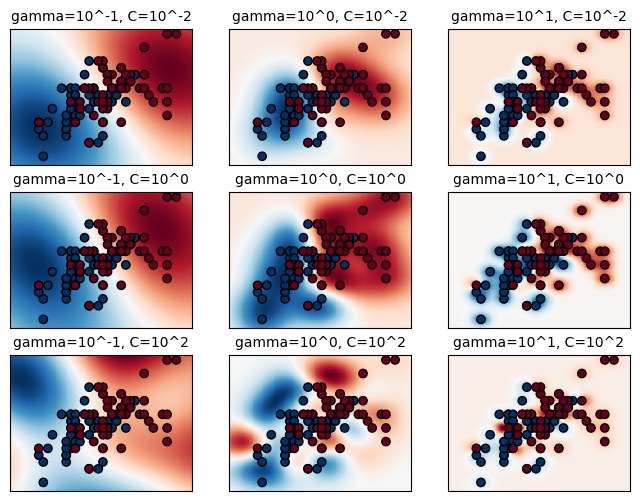

In [16]:
# VISUALIZATION
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
xx, yy = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
for k, (C, gamma, clf) in enumerate(classifiers):
    # evaluate decision function in a grid
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # visualize decision function for these parameters
    plt.subplot(len(C_2d_range), len(gamma_2d_range), k + 1)
    plt.title("gamma=10^%d, C=10^%d" % (np.log10(gamma), np.log10(C)), size="medium")

    # visualize parameter's effect on decision function
    plt.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu)
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, cmap=plt.cm.RdBu_r, edgecolors="k")
    plt.xticks(())
    plt.yticks(())
    plt.axis("tight")

scores = grid.cv_results_["mean_test_score"].reshape(len(C_range), len(gamma_range))

Draw heatmap of the validation accuracy as a function of gamma and C

The score are encoded as colors with the hot colormap which varies from dark red to bright yellow. As the most interesting scores are all located in the 0.92 to 0.97 range we use a custom normalizer to set the mid-point to 0.92 so as to make it easier to visualize the small variations of score values in the interesting range while not brutally collapsing all the low score values to the same color.

In [17]:
import numpy as np
from matplotlib.colors import Normalize

# Utility class to move the midpoint of a colormap to be around the values of interest.
class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

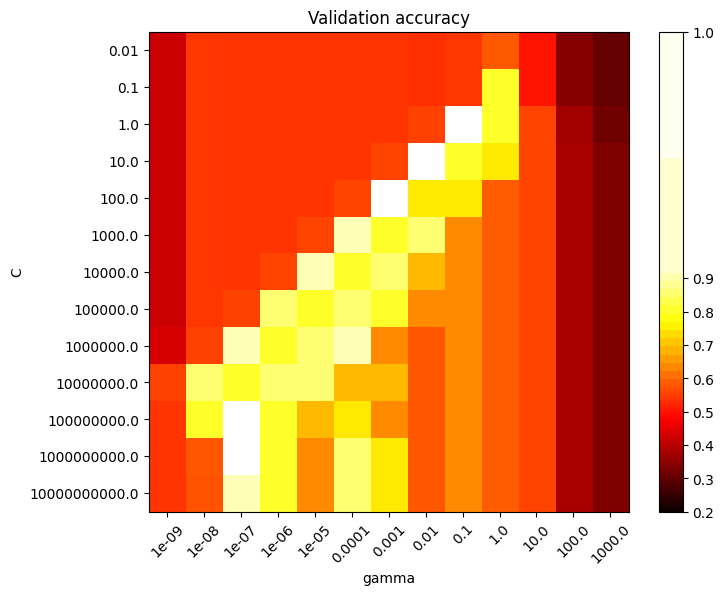

In [18]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap=plt.cm.hot,
    norm=MidpointNormalize(vmin=0.2, midpoint=0.92),
)
plt.xlabel("gamma")
plt.ylabel("C")
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title("Validation accuracy")
plt.show()